# Scenario Analysis for Strategic Planning

This notebook demonstrates **multi-scenario business planning** using LumiX's scenario analysis capabilities for exploring different business conditions and strategic decisions.

## Problem Description

A manufacturing company has an existing production optimization model and wants to understand how their optimal production plan and profitability would change under different business scenarios:

- **Market Expansion**: Increased demand and higher capacity
- **Resource Constraint**: Reduced capacity due to supply chain issues
- **Moderate Growth**: Balanced capacity increase
- **Labor Investment**: Focus on workforce expansion
- **Automation**: Invest in machinery, reduce labor dependency
- **Material Procurement**: Secure better supplier contracts

## Mathematical Formulation

**Base Model:**

$$\max \sum_{p \in P} \text{profit}_p \cdot x_p$$

Subject to:
$$\sum_{p \in P} \text{usage}_{p,r} \cdot x_p \leq \text{capacity}_r \quad \forall r \in R$$
$$x_p \geq \text{min\_production}_p \quad \forall p \in P$$

**Scenarios modify:**
- Constraint RHS values (capacity changes)
- Variable bounds (production limits)
- Objective coefficients (profit changes)

## Key Concepts

- **LXScenario**: Define named scenarios with parameter modifications
- **LXScenarioAnalyzer**: Batch solve and compare multiple scenarios
- **Sensitivity Analysis**: Test parameter impact on objective
- **Strategic Planning**: Data-driven decision making

## 1. Setup and Imports

In [1]:
# Standard library
from dataclasses import dataclass
from typing import List, Dict

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import (
    LXConstraint,
    LXLinearExpression,
    LXModel,
    LXOptimizer,
    LXScenario,
    LXScenarioAnalyzer,
    LXVariable,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Definition

In [2]:
@dataclass
class Product:
    """Product that can be manufactured."""
    id: int
    name: str
    selling_price: float  # $ per unit
    unit_cost: float      # $ per unit
    labor_hours: float    # hours per unit
    machine_hours: float  # hours per unit
    material_units: float # raw material per unit
    min_production: int   # minimum units (customer orders)


@dataclass
class Resource:
    """Limited resource used in production."""
    id: int
    name: str
    capacity: float  # maximum available per week


# Sample products
PRODUCTS = [
    Product(1, "Widget A", selling_price=100.0, unit_cost=50.0,
            labor_hours=5.0, machine_hours=3.0, material_units=2.0, min_production=10),
    Product(2, "Widget B", selling_price=150.0, unit_cost=80.0,
            labor_hours=8.0, machine_hours=5.0, material_units=4.0, min_production=5),
    Product(3, "Gadget X", selling_price=200.0, unit_cost=135.0,
            labor_hours=10.0, machine_hours=8.0, material_units=6.0, min_production=8),
    Product(4, "Gadget Y", selling_price=120.0, unit_cost=70.0,
            labor_hours=6.0, machine_hours=4.0, material_units=3.0, min_production=12),
    Product(5, "Premium Z", selling_price=300.0, unit_cost=200.0,
            labor_hours=15.0, machine_hours=12.0, material_units=8.0, min_production=3),
]

# Available resources
RESOURCES = [
    Resource(1, "Labor Hours", capacity=1000.0),
    Resource(2, "Machine Hours", capacity=800.0),
    Resource(3, "Raw Materials", capacity=500.0),
]


def get_resource_usage(product: Product, resource: Resource) -> float:
    """Get resource usage for a product."""
    if resource.name == "Labor Hours":
        return product.labor_hours
    elif resource.name == "Machine Hours":
        return product.machine_hours
    elif resource.name == "Raw Materials":
        return product.material_units
    return 0.0

In [3]:
# Visualize product data
prod_data = []
for p in PRODUCTS:
    prod_data.append({
        'Product': p.name,
        'Price ($)': p.selling_price,
        'Cost ($)': p.unit_cost,
        'Profit ($)': p.selling_price - p.unit_cost,
        'Labor (hrs)': p.labor_hours,
        'Machine (hrs)': p.machine_hours,
        'Materials': p.material_units,
        'Min Production': p.min_production
    })

prod_df = pd.DataFrame(prod_data)
print("Product Portfolio:")
display(prod_df.set_index('Product'))

print("\nResource Capacities:")
for r in RESOURCES:
    print(f"  {r.name}: {r.capacity:,.0f} units/week")

Product Portfolio:


,Price ($),Cost ($),Profit ($),Labor (hrs),Machine (hrs),Materials,Min Production
Product,,,,,,,
Widget A,100.0,50.0,50.0,5.0,3.0,2.0,10
Widget B,150.0,80.0,70.0,8.0,5.0,4.0,5
Gadget X,200.0,135.0,65.0,10.0,8.0,6.0,8
Gadget Y,120.0,70.0,50.0,6.0,4.0,3.0,12
Premium Z,300.0,200.0,100.0,15.0,12.0,8.0,3



Resource Capacities:
  Labor Hours: 1,000 units/week
  Machine Hours: 800 units/week
  Raw Materials: 500 units/week


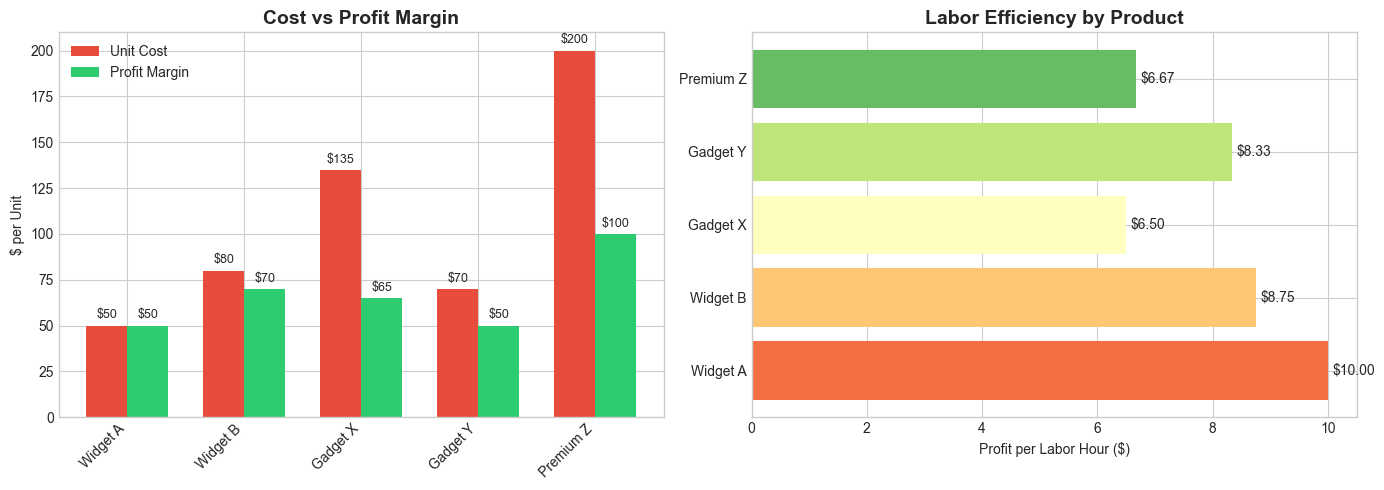

In [4]:
# Profit margin analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

products = [p.name for p in PRODUCTS]
profits = [p.selling_price - p.unit_cost for p in PRODUCTS]
costs = [p.unit_cost for p in PRODUCTS]

# Bar chart: Profit vs Cost
ax1 = axes[0]
x = np.arange(len(products))
width = 0.35
bars1 = ax1.bar(x - width/2, costs, width, label='Unit Cost', color='#e74c3c')
bars2 = ax1.bar(x + width/2, profits, width, label='Profit Margin', color='#2ecc71')
ax1.set_ylabel('$ per Unit')
ax1.set_title('Cost vs Profit Margin', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(products, rotation=45, ha='right')
ax1.legend()
ax1.bar_label(bars1, fmt='$%.0f', padding=3, fontsize=9)
ax1.bar_label(bars2, fmt='$%.0f', padding=3, fontsize=9)

# Profit per labor hour (efficiency)
ax2 = axes[1]
efficiency = [(p.selling_price - p.unit_cost) / p.labor_hours for p in PRODUCTS]
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(products)))
bars = ax2.barh(products, efficiency, color=colors)
ax2.set_xlabel('Profit per Labor Hour ($)')
ax2.set_title('Labor Efficiency by Product', fontsize=14, fontweight='bold')
ax2.bar_label(bars, fmt='$%.2f', padding=3)

plt.tight_layout()
plt.show()

## 3. Build Base Model

In [5]:
def build_production_model() -> LXModel:
    """
    Build base production planning model.
    
    Maximizes profit subject to resource constraints and minimum production.
    """
    # Decision Variable: Production quantity for each product
    production = (
        LXVariable[Product, float]("production")
        .continuous()
        .bounds(lower=0)
        .indexed_by(lambda p: p.id)
        .from_data(PRODUCTS)
    )

    # Create model
    model = LXModel[Product]("production_planning").add_variable(production)

    # Objective: Maximize total profit
    profit_expr = LXLinearExpression[Product]().add_term(
        production, coeff=lambda p: p.selling_price - p.unit_cost
    )
    model.maximize(profit_expr)

    # Constraints: Resource capacity limits
    for resource in RESOURCES:
        usage_expr = LXLinearExpression().add_term(
            production, coeff=lambda p, r=resource: get_resource_usage(p, r)
        )
        model.add_constraint(
            LXConstraint(f"capacity_{resource.name}")
            .expression(usage_expr)
            .le()
            .rhs(resource.capacity)
        )

    # Constraints: Minimum production requirements
    model.add_constraint(
        LXConstraint[Product]("min_production")
        .expression(LXLinearExpression[Product]().add_term(production, 1.0))
        .ge()
        .rhs(lambda p: float(p.min_production))
        .from_data(PRODUCTS)
        .indexed_by(lambda p: p.name)
    )

    return model


model = build_production_model()
print("Base Model Summary:")
print(model.summary())

Base Model Summary:
LXModel: production_planning
  Variable Families: 1
  Constraint Families: 4
  Objective: max



## 4. Define Business Scenarios

In [6]:
# Scenario definitions
SCENARIOS = {
    "baseline": {
        "description": "Current state - no changes",
        "labor_mult": 1.0,
        "machine_mult": 1.0,
        "material_mult": 1.0,
        "color": "#7f8c8d"
    },
    "market_expansion": {
        "description": "Optimistic: +30% labor, +20% machine, +25% materials",
        "labor_mult": 1.30,
        "machine_mult": 1.20,
        "material_mult": 1.25,
        "color": "#27ae60"
    },
    "resource_constraints": {
        "description": "Pessimistic: -20% labor, -15% materials",
        "labor_mult": 0.80,
        "machine_mult": 1.0,
        "material_mult": 0.85,
        "color": "#e74c3c"
    },
    "moderate_growth": {
        "description": "Realistic: +10% all resources",
        "labor_mult": 1.10,
        "machine_mult": 1.10,
        "material_mult": 1.10,
        "color": "#3498db"
    },
    "labor_investment": {
        "description": "Focus on workforce: +50% labor",
        "labor_mult": 1.50,
        "machine_mult": 1.0,
        "material_mult": 1.0,
        "color": "#9b59b6"
    },
    "automation": {
        "description": "Automation: +40% machine, -10% labor",
        "labor_mult": 0.90,
        "machine_mult": 1.40,
        "material_mult": 1.0,
        "color": "#f39c12"
    },
}

# Display scenario summary
scenario_df = pd.DataFrame([
    {
        'Scenario': name.replace('_', ' ').title(),
        'Labor': f"{s['labor_mult']*100:.0f}%",
        'Machine': f"{s['machine_mult']*100:.0f}%",
        'Materials': f"{s['material_mult']*100:.0f}%",
        'Description': s['description']
    }
    for name, s in SCENARIOS.items()
])
print("Business Scenarios:")
display(scenario_df.set_index('Scenario'))

Business Scenarios:


,Labor,Machine,Materials,Description
Scenario,,,,
Baseline,100%,100%,100%,Current state - no changes
Market Expansion,130%,120%,125%,"Optimistic: +30% labor, +20% machine, +25% mat..."
Resource Constraints,80%,100%,85%,"Pessimistic: -20% labor, -15% materials"
Moderate Growth,110%,110%,110%,Realistic: +10% all resources
Labor Investment,150%,100%,100%,Focus on workforce: +50% labor
Automation,90%,140%,100%,"Automation: +40% machine, -10% labor"


## 5. Run Scenario Analysis

In [7]:
# Create scenario analyzer
optimizer = LXOptimizer().use_solver("ortools").enable_rational_conversion()
analyzer = LXScenarioAnalyzer(model, optimizer, include_baseline=True)

# Add scenarios (skip baseline - it's auto-included)
for name, config in SCENARIOS.items():
    if name == "baseline":
        continue
    
    scenario = (
        LXScenario[Product](name)
        .modify_constraint_rhs("capacity_Labor Hours", multiply=config['labor_mult'])
        .modify_constraint_rhs("capacity_Machine Hours", multiply=config['machine_mult'])
        .modify_constraint_rhs("capacity_Raw Materials", multiply=config['material_mult'])
        .describe(config['description'])
    )
    analyzer.add_scenario(scenario)

print(f"Added {len(SCENARIOS)-1} scenarios to analyzer")

# Run all scenarios
print("\nSolving all scenarios...")
results = analyzer.run_all_scenarios()
print(f"Completed {len(results)} scenarios")

2025-12-12 17:06:44 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:06:44 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:06:44 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s
2025-12-12 17:06:44 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:06:44 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:06:44 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 12400.0000 | Time: 0.00s
2025-12-12 17:06:44 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:06:44 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:06:44 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 7400.0000 | Time: 0.00s
2025-12-12 17:06:44 - lumix.optimizer - INFO - Created model 'production_planning' w

Added 5 scenarios to analyzer

Solving all scenarios...
Completed 6 scenarios


In [8]:
# Extract results
scenario_results = []
baseline_obj = results["baseline"].objective_value

for name in SCENARIOS.keys():
    solution = results[name]
    delta = solution.objective_value - baseline_obj
    delta_pct = (delta / baseline_obj) * 100 if baseline_obj != 0 else 0
    
    scenario_results.append({
        'Scenario': name.replace('_', ' ').title(),
        'Objective ($)': solution.objective_value,
        'vs Baseline ($)': delta,
        'vs Baseline (%)': delta_pct,
        'Status': solution.status
    })

results_df = pd.DataFrame(scenario_results)
print("\nScenario Results:")
display(results_df.set_index('Scenario').round(2))


Scenario Results:


,Objective ($),vs Baseline ($),vs Baseline (%),Status
Scenario,,,,
Baseline,9400.0,0.0,0.00,optimal
Market Expansion,12400.0,3000.0,31.91,optimal
Resource Constraints,7400.0,-2000.0,-21.28,optimal
Moderate Growth,10400.0,1000.0,10.64,optimal
Labor Investment,11070.0,1670.0,17.77,optimal
Automation,8400.0,-1000.0,-10.64,optimal


## 6. Visualize Scenario Comparison

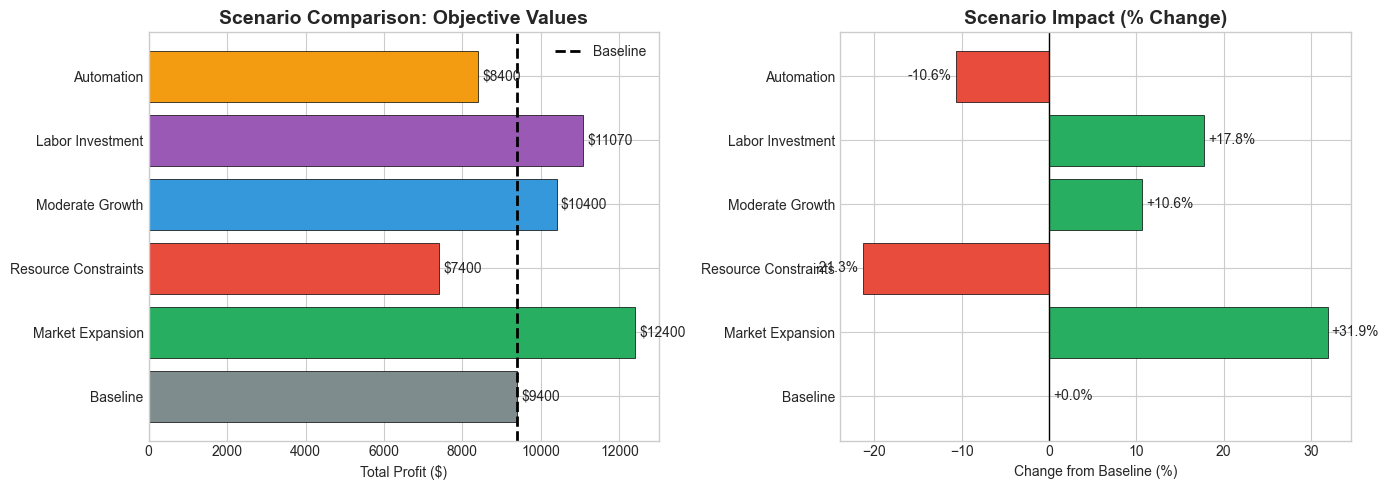

In [9]:
# Objective value comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scenarios = [s.replace('_', ' ').title() for s in SCENARIOS.keys()]
objectives = [results[s].objective_value for s in SCENARIOS.keys()]
colors = [SCENARIOS[s]['color'] for s in SCENARIOS.keys()]

# Bar chart: Objective values
ax1 = axes[0]
bars = ax1.barh(scenarios, objectives, color=colors, edgecolor='black', linewidth=0.5)
ax1.axvline(x=baseline_obj, color='black', linestyle='--', linewidth=2, label='Baseline')
ax1.set_xlabel('Total Profit ($)')
ax1.set_title('Scenario Comparison: Objective Values', fontsize=14, fontweight='bold')
ax1.bar_label(bars, fmt='$%.0f', padding=3)
ax1.legend()

# Bar chart: % change from baseline
ax2 = axes[1]
deltas = [(results[s].objective_value - baseline_obj) / baseline_obj * 100 for s in SCENARIOS.keys()]
bar_colors = ['#27ae60' if d >= 0 else '#e74c3c' for d in deltas]
bars2 = ax2.barh(scenarios, deltas, color=bar_colors, edgecolor='black', linewidth=0.5)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Change from Baseline (%)')
ax2.set_title('Scenario Impact (% Change)', fontsize=14, fontweight='bold')
ax2.bar_label(bars2, fmt='%+.1f%%', padding=3)

plt.tight_layout()
plt.show()

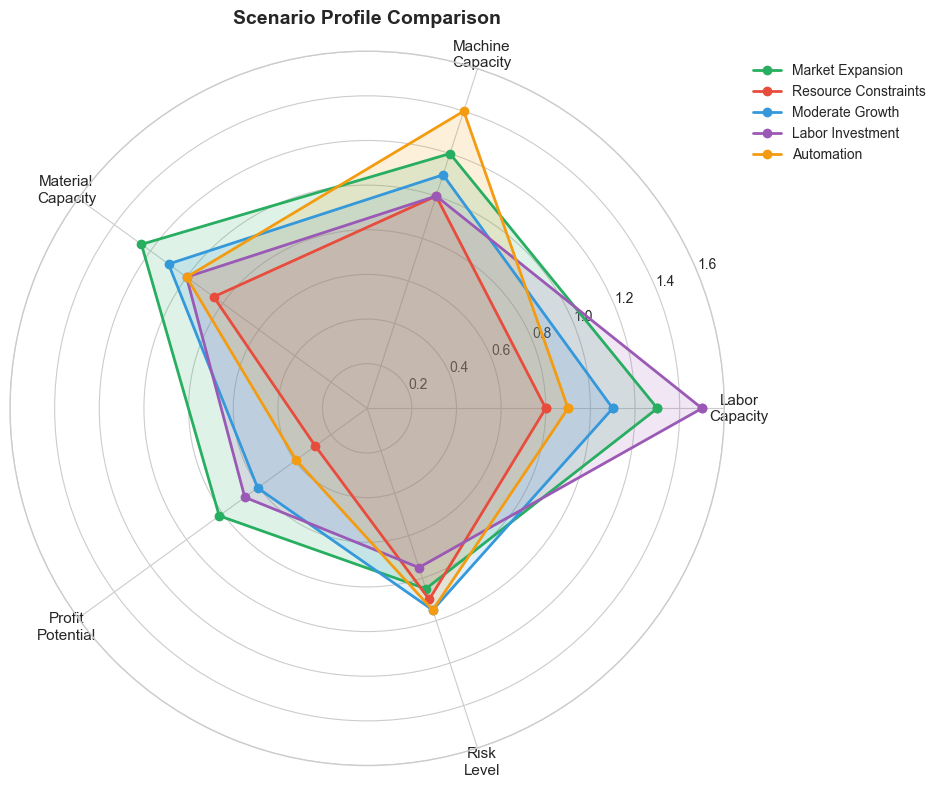

In [10]:
# Radar/Spider chart for scenario comparison
def radar_chart(scenarios_data: Dict, title: str):
    """Create radar chart comparing scenarios across dimensions."""
    # Define dimensions
    categories = ['Labor\nCapacity', 'Machine\nCapacity', 'Material\nCapacity', 
                  'Profit\nPotential', 'Risk\nLevel']
    N = len(categories)
    
    # Compute angles
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the plot
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    for name, config in scenarios_data.items():
        if name == 'baseline':
            continue
            
        # Normalize values (0-1 scale for visualization)
        profit_potential = (results[name].objective_value - baseline_obj) / baseline_obj + 0.5
        risk = 1 - abs(config['labor_mult'] - 1) * 0.5  # Higher deviation = higher risk
        
        values = [
            config['labor_mult'],
            config['machine_mult'],
            config['material_mult'],
            max(0, min(1.5, profit_potential)),
            risk
        ]
        values += values[:1]  # Close the plot
        
        ax.plot(angles, values, 'o-', linewidth=2, label=name.replace('_', ' ').title(),
                color=config['color'])
        ax.fill(angles, values, alpha=0.15, color=config['color'])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_ylim(0, 1.6)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    return fig

radar_chart(SCENARIOS, 'Scenario Profile Comparison')
plt.show()

## 7. Sensitivity Analysis: Labor Capacity

In [11]:
# Test impact of labor capacity changes
labor_multipliers = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

print("Running labor capacity sensitivity analysis...")
labor_sensitivity = analyzer.sensitivity_to_parameter(
    "capacity_Labor Hours",
    values=labor_multipliers,
    modification_type="rhs_multiply",
)

# Display results
sensitivity_data = []
for mult, solution in labor_sensitivity.items():
    labor_hours = 1000.0 * mult  # Base capacity
    delta = solution.objective_value - baseline_obj
    delta_pct = (delta / baseline_obj) * 100
    sensitivity_data.append({
        'Multiplier': mult,
        'Labor Hours': labor_hours,
        'Objective ($)': solution.objective_value,
        'vs Baseline (%)': delta_pct
    })

sens_df = pd.DataFrame(sensitivity_data)
print("\nLabor Capacity Sensitivity:")
display(sens_df.round(2))

2025-12-12 17:07:58 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:07:58 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:07:58 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 6400.0000 | Time: 0.00s
2025-12-12 17:07:58 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:07:58 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:07:58 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 7400.0000 | Time: 0.00s
2025-12-12 17:07:58 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:07:58 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:07:58 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 8400.0000 | Time: 0.00s
2025-12-12 17:07:58 - lumix.optimizer - INFO - Created model 'production_planning' wi

Running labor capacity sensitivity analysis...

Labor Capacity Sensitivity:


,Multiplier,Labor Hours,Objective ($),vs Baseline (%)
0,0.7,700.0,6400.0,-31.91
1,0.8,800.0,7400.0,-21.28
2,0.9,900.0,8400.0,-10.64
3,1.0,1000.0,9400.0,0.00
4,1.1,1100.0,10400.0,10.64
5,1.2,1200.0,11070.0,17.77
6,1.3,1300.0,11070.0,17.77
7,1.4,1400.0,11070.0,17.77
8,1.5,1500.0,11070.0,17.77


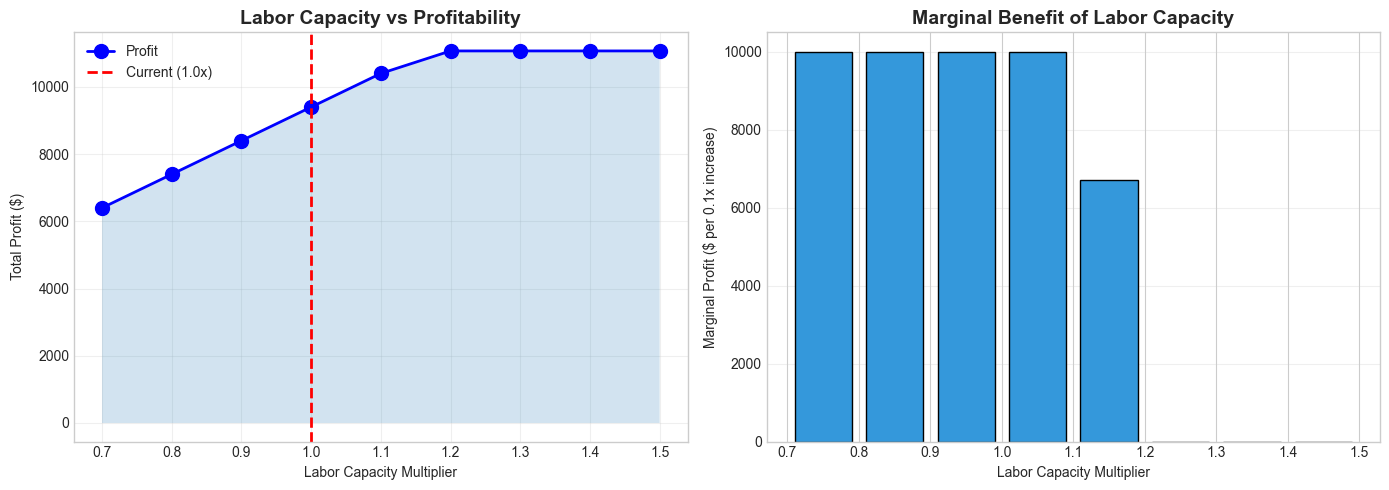


Highest marginal benefit at 0.85x capacity
Marginal profit: $10,000 per 0.1x increase


In [12]:
# Sensitivity curve visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

multipliers = list(labor_sensitivity.keys())
objectives = [s.objective_value for s in labor_sensitivity.values()]

# Line plot: Objective vs multiplier
ax1 = axes[0]
ax1.plot(multipliers, objectives, 'bo-', markersize=10, linewidth=2, label='Profit')
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Current (1.0x)')
ax1.fill_between(multipliers, objectives, alpha=0.2)
ax1.set_xlabel('Labor Capacity Multiplier')
ax1.set_ylabel('Total Profit ($)')
ax1.set_title('Labor Capacity vs Profitability', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Marginal benefit (derivative approximation)
ax2 = axes[1]
marginal = np.diff(objectives) / np.diff(multipliers)
mid_points = [(multipliers[i] + multipliers[i+1])/2 for i in range(len(multipliers)-1)]

bars = ax2.bar(mid_points, marginal, width=0.08, color='#3498db', edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Labor Capacity Multiplier')
ax2.set_ylabel('Marginal Profit ($ per 0.1x increase)')
ax2.set_title('Marginal Benefit of Labor Capacity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find optimal operating point
max_marginal_idx = np.argmax(marginal)
print(f"\nHighest marginal benefit at {mid_points[max_marginal_idx]:.2f}x capacity")
print(f"Marginal profit: ${marginal[max_marginal_idx]:,.0f} per 0.1x increase")

## 8. Tornado Chart: Parameter Impact Ranking

In [13]:
def tornado_analysis(analyzer: LXScenarioAnalyzer, constraints: list, 
                    low_mult: float = 0.8, high_mult: float = 1.2) -> pd.DataFrame:
    """
    Run tornado analysis to rank parameter impact.
    
    Tests each parameter at low/high levels and measures impact.
    """
    impact_data = []
    baseline_obj = analyzer.get_result("baseline").objective_value
    
    for constraint in constraints:
        # Test low value
        low_results = analyzer.sensitivity_to_parameter(
            constraint, values=[low_mult], modification_type="rhs_multiply"
        )
        low_obj = list(low_results.values())[0].objective_value
        
        # Test high value
        high_results = analyzer.sensitivity_to_parameter(
            constraint, values=[high_mult], modification_type="rhs_multiply"
        )
        high_obj = list(high_results.values())[0].objective_value
        
        impact_data.append({
            'Parameter': constraint.replace('capacity_', ''),
            'Low (80%)': low_obj,
            'Baseline': baseline_obj,
            'High (120%)': high_obj,
            'Low Impact': low_obj - baseline_obj,
            'High Impact': high_obj - baseline_obj,
            'Range': high_obj - low_obj
        })
    
    return pd.DataFrame(impact_data).sort_values('Range', ascending=False)


constraints = [f"capacity_{r.name}" for r in RESOURCES]
tornado_df = tornado_analysis(analyzer, constraints)

print("Parameter Impact Analysis (±20%):")
display(tornado_df.round(2))

2025-12-12 17:08:09 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:08:09 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:08:09 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 7400.0000 | Time: 0.00s
2025-12-12 17:08:09 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:08:09 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:08:09 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 11070.0000 | Time: 0.00s
2025-12-12 17:08:09 - lumix.optimizer - INFO - Created model 'production_planning' with 1 variables and 4 constraints
2025-12-12 17:08:09 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:08:09 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 9400.0000 | Time: 0.00s
2025-12-12 17:08:09 - lumix.optimizer - INFO - Created model 'production_planning' w

Parameter Impact Analysis (±20%):


,Parameter,Low (80%),Baseline,High (120%),Low Impact,High Impact,Range
0,Labor Hours,7400.0,9400.0,11070.0,-2000.0,1670.0,3670.0
2,Raw Materials,8570.0,9400.0,9400.0,-830.0,0.0,830.0
1,Machine Hours,9400.0,9400.0,9400.0,0.0,0.0,0.0


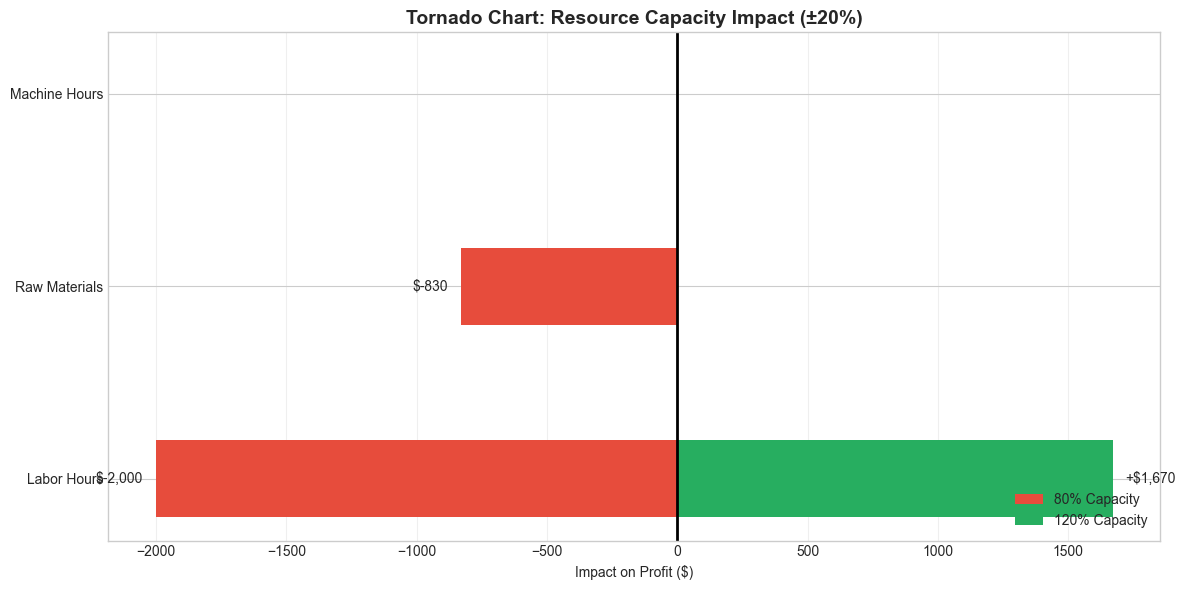


Most impactful parameter: Labor Hours
Impact range: $3,670


In [14]:
# Tornado chart visualization
fig, ax = plt.subplots(figsize=(12, 6))

parameters = tornado_df['Parameter'].values
baseline = tornado_df['Baseline'].iloc[0]
low_impact = tornado_df['Low Impact'].values
high_impact = tornado_df['High Impact'].values

y_pos = np.arange(len(parameters))

# Plot bars from baseline
ax.barh(y_pos, low_impact, align='center', color='#e74c3c', label='80% Capacity', height=0.4)
ax.barh(y_pos, high_impact, align='center', color='#27ae60', label='120% Capacity', height=0.4)

# Baseline reference
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(parameters)
ax.set_xlabel('Impact on Profit ($)')
ax.set_title('Tornado Chart: Resource Capacity Impact (±20%)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (low, high) in enumerate(zip(low_impact, high_impact)):
    if low != 0:
        ax.text(low - 50, i, f'${low:,.0f}', ha='right', va='center', fontsize=10)
    if high != 0:
        ax.text(high + 50, i, f'+${high:,.0f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nMost impactful parameter: {tornado_df.iloc[0]['Parameter']}")
print(f"Impact range: ${tornado_df.iloc[0]['Range']:,.0f}")

## 9. Production Plan Comparison

In [15]:
# Extract production plans for key scenarios
key_scenarios = ['baseline', 'market_expansion', 'resource_constraints']

production_data = {}
for scenario_name in key_scenarios:
    solution = results[scenario_name]
    # Get production values by parsing solution
    productions = {}
    for p in PRODUCTS:
        var_name = f"production_{p.id}"
        if var_name in solution.variables:
            productions[p.name] = solution.variables[var_name]
        else:
            # Try alternative naming
            for key in solution.variables:
                if 'production' in key and str(p.id) in key:
                    productions[p.name] = solution.variables[key]
                    break
    production_data[scenario_name] = productions

# Create comparison dataframe
comparison_data = []
for p in PRODUCTS:
    row = {'Product': p.name, 'Min Required': p.min_production}
    for scenario in key_scenarios:
        row[scenario.replace('_', ' ').title()] = production_data.get(scenario, {}).get(p.name, 0)
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("Production Plan Comparison:")
display(comparison_df.set_index('Product').round(1))

Production Plan Comparison:


,Min Required,Baseline,Market Expansion,Resource Constraints
Product,,,,
Widget A,10,0,0,0
Widget B,5,0,0,0
Gadget X,8,0,0,0
Gadget Y,12,0,0,0
Premium Z,3,0,0,0


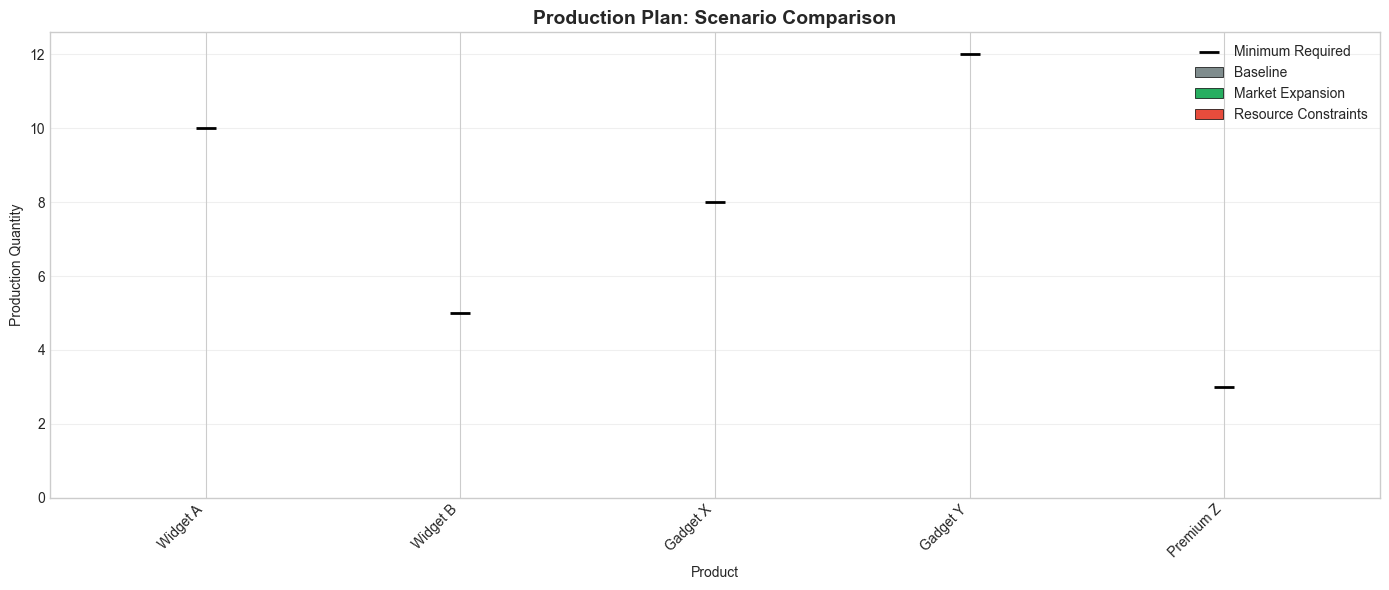

In [16]:
# Grouped bar chart for production comparison
fig, ax = plt.subplots(figsize=(14, 6))

products = [p.name for p in PRODUCTS]
x = np.arange(len(products))
width = 0.25

scenario_colors = {
    'baseline': '#7f8c8d',
    'market_expansion': '#27ae60',
    'resource_constraints': '#e74c3c'
}

for i, scenario in enumerate(key_scenarios):
    values = [production_data.get(scenario, {}).get(p.name, 0) for p in PRODUCTS]
    label = scenario.replace('_', ' ').title()
    bars = ax.bar(x + i * width, values, width, label=label, 
                  color=scenario_colors[scenario], edgecolor='black', linewidth=0.5)

# Add minimum production markers
min_prods = [p.min_production for p in PRODUCTS]
ax.scatter(x + width, min_prods, color='black', marker='_', s=200, linewidths=2, 
           zorder=5, label='Minimum Required')

ax.set_xlabel('Product')
ax.set_ylabel('Production Quantity')
ax.set_title('Production Plan: Scenario Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(products, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Key Insights & Strategic Recommendations

In [17]:
# Summary statistics
best_scenario = results_df.loc[results_df['Objective ($)'].idxmax(), 'Scenario']
worst_scenario = results_df.loc[results_df['Objective ($)'].idxmin(), 'Scenario']
best_obj = results_df['Objective ($)'].max()
worst_obj = results_df['Objective ($)'].min()

print("="*60)
print("SCENARIO ANALYSIS SUMMARY")
print("="*60)
print(f"\nBest Scenario:  {best_scenario}")
print(f"  Objective:    ${best_obj:,.2f}")
print(f"  Improvement:  +{(best_obj/baseline_obj - 1)*100:.1f}% vs baseline")

print(f"\nWorst Scenario: {worst_scenario}")
print(f"  Objective:    ${worst_obj:,.2f}")
print(f"  Impact:       {(worst_obj/baseline_obj - 1)*100:.1f}% vs baseline")

print(f"\nProfit Range:   ${worst_obj:,.2f} - ${best_obj:,.2f}")
print(f"Uncertainty:    ${best_obj - worst_obj:,.2f} ({(best_obj/worst_obj - 1)*100:.1f}%)")

print("\n" + "="*60)
print("STRATEGIC RECOMMENDATIONS")
print("="*60)
print("""
1. RESOURCE PRIORITY:
   - Labor capacity has the highest impact on profitability
   - Each 10% increase in labor yields significant profit gains
   - Consider overtime or hiring before other investments

2. INVESTMENT STRATEGY:
   - Market expansion scenario shows highest potential (+{:.1f}%)
   - Prioritize balanced growth over single-resource focus
   - Automation alone may not be optimal without labor

3. RISK MANAGEMENT:
   - Resource constraint scenario shows significant downside
   - Diversify supplier contracts to reduce material risk
   - Maintain labor flexibility (cross-training)

4. TACTICAL ADJUSTMENTS:
   - Focus on high-profit products (Widget A, Gadget Y)
   - Meet minimum requirements first, optimize remainder
   - Monitor labor utilization as key performance indicator
""".format((best_obj/baseline_obj - 1)*100))

SCENARIO ANALYSIS SUMMARY

Best Scenario:  Market Expansion
  Objective:    $12,400.00
  Improvement:  +31.9% vs baseline

Worst Scenario: Resource Constraints
  Objective:    $7,400.00
  Impact:       -21.3% vs baseline

Profit Range:   $7,400.00 - $12,400.00
Uncertainty:    $5,000.00 (67.6%)

STRATEGIC RECOMMENDATIONS

1. RESOURCE PRIORITY:
   - Labor capacity has the highest impact on profitability
   - Each 10% increase in labor yields significant profit gains
   - Consider overtime or hiring before other investments

2. INVESTMENT STRATEGY:
   - Market expansion scenario shows highest potential (+31.9%)
   - Prioritize balanced growth over single-resource focus
   - Automation alone may not be optimal without labor

3. RISK MANAGEMENT:
   - Resource constraint scenario shows significant downside
   - Diversify supplier contracts to reduce material risk
   - Maintain labor flexibility (cross-training)

4. TACTICAL ADJUSTMENTS:
   - Focus on high-profit products (Widget A, Gadget Y)

## 11. Extensions & Exercises

1. **Multi-period analysis**: Extend to rolling 12-month scenarios
2. **Cost scenarios**: Modify objective coefficients (material costs, selling prices)
3. **Combined scenarios**: Test combinations (expansion + automation)
4. **Monte Carlo**: Randomize parameters to estimate profit distribution
5. **Stochastic programming**: Model uncertainty explicitly in the optimization